# Named Entity Recognition (NER)

## Usando un modelo pre-entrenado de SpaCy

En esta sección simplemente vamos a usar un modelo pre-entrenado de SpaCy para identificar entidades nombradas

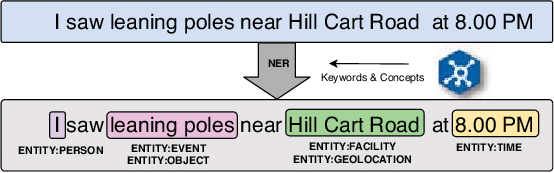

Para ello realizaremos las siguientes tareas:

- Importaciones

In [3]:
import spacy
import pickle
import random
from spacy import displacy # Para representar las entidades nombradas

- Cargamos el modelo de SpaCy, en el idioma que deseemos

In [4]:
nlp = spacy.load('en')

- Procesamos la frase, para obtener las entidades nombradas

In [10]:
frase = '''My name is Amar Sharma, i stay in Mumbai.
The 2020 america presidential election is scheduled for Tuesday, November 3.'''

documento = nlp(frase)
for ent in documento.ents: # Iteramos por todas las entidades nombradas, y pintamos tipo, y texto
  print(f'{ent.label_.upper():{10}}:{spacy.explain(ent.label_):{50}}- {ent.text}')

PERSON    :People, including fictional                       - Amar Sharma
GPE       :Countries, cities, states                         - Mumbai
DATE      :Absolute or relative dates or periods             - 2020
GPE       :Countries, cities, states                         - america
DATE      :Absolute or relative dates or periods             - Tuesday, November 3


- Lo podemos pintar usando **displacy**

In [11]:
displacy.render(documento, style="ent",jupyter=True)

## Entrenando un modelo propio

Dependiendo del dominio del problema, puede ser que los modelos pre-entrenados, para reconocimiento de entidades nombradas, trabajen de forma erronea, ya que fueron creados para un proposito general, y nosotros queremos usarlos para un proposito particular

### Conexión a Drive

In [49]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
PATH_DATA= '/content/drive/MyDrive/Colab Notebooks/nlp_introduction_course/data'
PATH_MODEL= '/content/drive/MyDrive/Colab Notebooks/nlp_introduction_course/models'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Usando el modelo pre-entrenado

- Descargando PyMuPDF para procesar PDF

In [13]:
!pip install PyMuPDF

     |████████████████████████████████| 8.8 MB 23.0 MB/s 


- Lectura del CV en formato PDF y conversión a texto

In [15]:
import sys,fitz
file_name = 'Alice Clark CV.pdf'
doc= fitz.open(f'{PATH_DATA}/{file_name}')
alice_cv=""
for page in doc:
  alice_cv = alice_cv + str(page.get_text())

print(alice_cv)

Alice Clark 
AI / Machine Learning 
 
Delhi, India Email me on Indeed 
• 
20+ years of experience in data handling, design, and development 
• 
Data Warehouse: Data analysis, star/snow flake scema data modelling and design specific to 
data warehousing and business intelligence 
• 
Database: Experience in database designing, scalability, back-up and recovery, writing and 
optimizing SQL code and Stored Procedures, creating functions, views, triggers and indexes. 
Cloud platform: Worked on Microsoft Azure cloud services like Document DB, SQL Azure, 
Stream Analytics, Event hub, Power BI, Web Job, Web App, Power BI, Azure data lake 
analytics(U-SQL) 
Willing to relocate anywhere 
 
WORK EXPERIENCE 
Software Engineer 
Microsoft – Bangalore, Karnataka 
January 2000 to Present 
1. Microsoft Rewards Live dashboards: 
Description: - Microsoft rewards is loyalty program that rewards Users for browsing and shopping 
online. Microsoft Rewards members can earn points when searching with Bing, bro

- Usar el modelo entrenado para NER de SpaCY

In [17]:
nlp = spacy.load('en')
documento = nlp(" ".join(alice_cv.split('\n'))) # Dividimos el documento al encontrar salto de linea y lo unimos de nuevo con un espacio. 

- Mostramos las entidades nombradas

In [18]:
for ent in documento.ents: # Iteramos por todas las entidades nombradas, y pintamos tipo, y texto
  print(f'{ent.label_.upper():{10}}:{spacy.explain(ent.label_):{50}}- {ent.text}')

PERSON    :People, including fictional                       - Alice Clark
ORG       :Companies, agencies, institutions, etc.           - AI / Machine Learning
GPE       :Countries, cities, states                         - Delhi
GPE       :Countries, cities, states                         - India
DATE      :Absolute or relative dates or periods             - 20+ years
ORG       :Companies, agencies, institutions, etc.           - star/snow flake scema
ORG       :Companies, agencies, institutions, etc.           - SQL
PERSON    :People, including fictional                       - Stored Procedures
PERSON    :People, including fictional                       - Cloud
ORG       :Companies, agencies, institutions, etc.           - Microsoft Azure
PERSON    :People, including fictional                       - Document DB
ORG       :Companies, agencies, institutions, etc.           - SQL Azure
ORG       :Companies, agencies, institutions, etc.           - Stream Analytics
ORG       :Companies

- Lo mostramos con displacy

In [19]:
displacy.render(documento, style="ent",jupyter=True)

Podemos apreciar varios fallos, por ejemplo 

*   ORG       :Companies, agencies, institutions, etc.           - star/snow flake scema
* ORG       :Companies, agencies, institutions, etc.           - SQL
* PERSON    :People, including fictional                       - Stored Procedures
* PERSON    :People, including fictional                       - Cloud
* ORG       :Companies, agencies, institutions, etc.           - Microsoft Azure
* PERSON    :People, including fictional                       - Document DB
* ORG       :Companies, agencies, institutions, etc.           - SQL Azure
* ORG       :Companies, agencies, institutions, etc.           - Stream Analytics
* ORG       :Companies, agencies, institutions, etc.           - Power BI
* PERSON    :People, including fictional                       - Web Job
* PERSON    :People, including fictional                       - Web App



Vamos a cargar datos de entrenamiento, para intentar mejorar la precisión de la detección de entidades para este caso de uso

In [44]:
train_data = pickle.load(open(f'{PATH_DATA}/train_data.pkl','rb'))
print(f"Training data contiene {len(train_data)} CVs manualmente etiquetados.")

Training data contiene 200 CVs manualmente etiquetados.


Estructura de los datos de entrenamiento

- El primer indice (index[0]), contiene un texto de entrenamiento donde aparecen las entidades, en este caso el curriculum

In [30]:
train_data[97][0]

'Ramesh chokkala Telangana - Email me on Indeed: indeed.com/r/Ramesh-chokkala/16d5fa56f8c19eb6  WORK EXPERIENCE  software  Microsoft,Infosis, Google -  May 2018 to Present  software  Microsoft,Infosis, Google -  May 2018 to Present  EDUCATION  btech  Trinity engineering college  https://www.indeed.com/r/Ramesh-chokkala/16d5fa56f8c19eb6?isid=rex-download&ikw=download-top&co=IN'

- El segundo indice (index[1]), contiene una lista de tuplas, con las entidades que se encuentran en el texto, y el indice donde empieza la entidad y el indice de donde termina

In [35]:
train_data[97][1]

{'entities': [(250, 278, 'College Name'),
  (243, 248, 'Degree'),
  (182, 207, 'Companies worked at'),
  (172, 180, 'Designation'),
  (122, 147, 'Companies worked at'),
  (112, 120, 'Designation'),
  (48, 94, 'Email Address'),
  (16, 25, 'Location'),
  (0, 15, 'Name')]}

Vamos a extraer de este ejemplo las palabras que representan las entidades aplicando esta lógica

In [42]:
for tupla in train_data[97][1]['entities']:
  print(f'Entidad: {tupla[2]:{50}}Palabra en el texto: {train_data[97][0][tupla[0]:tupla[1]]}')

Entidad: College Name                                      Palabra en el texto: Trinity engineering college 
Entidad: Degree                                            Palabra en el texto: btech
Entidad: Companies worked at                               Palabra en el texto: Microsoft,Infosis, Google
Entidad: Designation                                       Palabra en el texto: software
Entidad: Companies worked at                               Palabra en el texto: Microsoft,Infosis, Google
Entidad: Designation                                       Palabra en el texto: software
Entidad: Email Address                                     Palabra en el texto: indeed.com/r/Ramesh-chokkala/16d5fa56f8c19eb6 
Entidad: Location                                          Palabra en el texto: Telangana
Entidad: Name                                              Palabra en el texto: Ramesh chokkala


### Entrenamiento del modelo usando los datos de entrenamiento

Creamos una instancia del modelo en blanco (sin entrenar, en ingles)

In [43]:
nlp = spacy.blank('en') 

A continuación se muestra el Pipeline del modelo que sera creado, cuando pasemos los datos de entrenamiento, hasta consegir el modelo entrenado

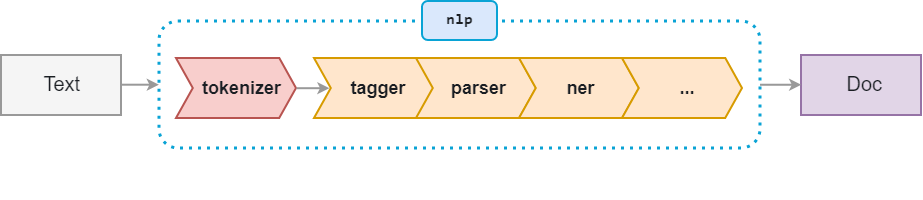

Función para entrenar el modelo

In [46]:
def entrenamiento(nlp,train_data, iterations):
  # Añadimos el reconocimiento de entidades al pipeline del proceso
  if 'ner' not in nlp.pipe_names:# Si no existe ner en los nombres del pipeline
    ner = nlp.create_pipe('ner') # creamos ner en el pipeline
    nlp.add_pipe(ner, last=True) # y la añadimos al final del pipeline

    for cv_text, entities in train_data: # Iteramos por cada CV
      for ent in entities['entities']: # Iteramos por cada entidad y obtenemos la tupla del tipo:  (indice_comienzo, indice_comienzo, Tipo de entidad)
        ner.add_label(ent[2]) # Añadimos a ner, el tipo de entidad
  # Añadimos el resto de procesos al pipeline
  other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'ner'] # Obtenemos todos los procesos excepto NER.

  with nlp.disable_pipes(*other_pipes): # Deshabilitamos los otros pipes por que solo queremos entrenar NER.
    optimizer = nlp.begin_training() # Comenzamos el entrenamiento

    for itn in range(iterations):         # Entrenamos el modelo para las iteraciones pasadas por parámetro
      print('Comenzando iteración ' + str(itn))
      random.shuffle(train_data) # Mezclamos los datos de entrenamiento, para hacer distinta cada iteración
      losses = {} # Perdidas
      for cv_text, entities in train_data:
        try:
          nlp.update(
              [cv_text],     # texto para entrenar
              [entities],    # entidades a entrenar
              drop=0.2,      # Ratio de eliminación de pesos,para evitar el sobreajuste
              sgd=optimizer, # Optimizador para optimizar los pesos
              losses=losses) # Diccionario para actualizar las perdidas.
        except Exception as e:
          pass

Y entrenamos el modelo

In [47]:
entrenamiento(nlp,train_data, 10)

Comenzando iteración 0
Comenzando iteración 1
Comenzando iteración 2
Comenzando iteración 3
Comenzando iteración 4
Comenzando iteración 5
Comenzando iteración 6
Comenzando iteración 7
Comenzando iteración 8
Comenzando iteración 9


Lo salvamos a disco para reusar el modelo si es necesario

In [50]:
nlp.to_disk(f'{PATH_MODEL}/nlp_ner_cv_model')

Tambien podemos leerlo de disco cuando sea necesario

In [51]:
nlp_model = spacy.load(f'{PATH_MODEL}/nlp_ner_cv_model')

Y vamos a usarlo mostrando los resultados, como hicimos anteriormente

In [52]:
documento = nlp_model(" ".join(alice_cv.split('\n'))) # Dividimos el documento al encontrar salto de linea y lo unimos de nuevo con un espacio. 

In [59]:
for ent in documento.ents: # Iteramos por todas las entidades nombradas, y pintamos tipo, y texto
  print(f'{ent.label_.upper():{20}} {ent.text}')

NAME                 Alice Clark
LOCATION             Delhi
DESIGNATION          Software Engineer
COLLEGE NAME         Indian Institute of Technology


In [55]:
displacy.render(documento, style="ent",jupyter=True)